# Simulations with large ptychographic scan steps (ie sparse scans) and with low values for the scattering amplitudes (ie weak).

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
from tqdm import tqdm_notebook as tqdm

from mbptycho.code.simulation import reloadSimulation, Simulation
from skimage.feature import register_translation
from skimage.restoration import unwrap_phase
from scipy import io
import copy
import os

cmap = copy.copy(mpl.cm.get_cmap('coolwarm'))
cmap.set_bad('black')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
base_path = os.environ['HOME']

In [4]:
base_path

'/home/skandel'

In [5]:
probe_2d = io.loadmat(f'{base_path}/code/mbptycho/experiments/matlab/datasets_0821/recon_probe_29902.mat')["prb"]
probes_3d_path = f'{base_path}/code/mbptycho/experiments/matlab/datasets_0821/probes.h5'

In [6]:
import h5py
probes_all = {}
with h5py.File(probes_3d_path, 'r') as f:
    for k in f.keys():
        probe = f[k][0] + 1j * f[k][1]
        # The tranpose op is for consistency with the probe loaded from .mat files.
        # In the earlier versions of the code, I designed the wave propagation around
        # the probe structure as stored in the .mat files. 
        probes_all[k] = probe.T

In [7]:
probe_rescaled = probe_2d / np.abs(probe_2d).max()
probe_trimmed = probe_rescaled.copy()
probe_2d[np.abs(probe_trimmed) < 0.02] = 0
np.sum(np.abs(probe_2d)**2), np.max(np.abs(probe_2d)**2)

(10405784.458692044, 523435.2684263936)

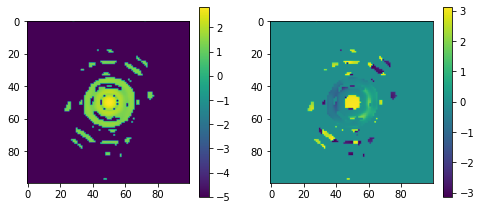

In [8]:
plt.figure(figsize=[8,3.5])
plt.subplot(121)
plt.imshow(np.log10(np.abs(probe_2d) + 1e-5))
plt.colorbar()
plt.subplot(122)
plt.imshow(np.angle(probe_2d))
plt.colorbar()
plt.show()

In [9]:
strain_type = 'point_inclusion'
data_path =  f'{base_path}/code/mbptycho/experiments/python/{strain_type}_sparse/weak_peaks'
sim_data_path = f'{data_path}/sim_{strain_type}.lz4'
sample_data_path = f'{data_path}/sample_{strain_type}.lz4'

save_plots = False

In [46]:
reload_sim = True

create_new_sample = False
if create_new_sample:
    reload_sample_only_filename = None
    save_sample_only_filename = sample_data_path
else:
    reload_sample_only_filename = sample_data_path
    save_sample_only_filename = sample_data_path

In [20]:
import joblib

In [21]:
test1 = joblib.load('sample_loaded_3.lz4')

In [29]:
joblib.dump(test1, sample_data_path)

['/home/skandel/code/mbptycho/experiments/python/point_inclusion_sparse/weak_peaks/sample_point_inclusion.lz4']

In [11]:
probes_all['120'].shape

(200, 200, 100)

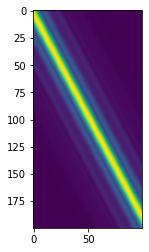

In [12]:
plt.imshow(np.abs(probes_all['120']).sum(axis=0))

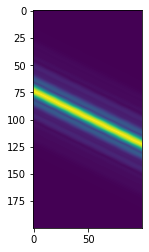

In [13]:
plt.imshow(np.abs(probes_all['210']).sum(axis=0))

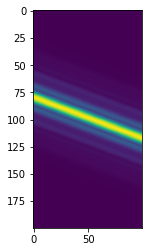

In [14]:
plt.imshow(np.abs(probes_all['110']).sum(axis=0))

In [15]:
illum_sums = {}

In [60]:
# The "magnitudes_scaling_per_peak" parameter sets the scattering amplitude per peak.

if reload_sim:
    sm = reloadSimulation(sim_data_path, reload_sim=True, 
                          reload_sample_only_filename=reload_sample_only_filename,
                          save_sample_only_filename=save_sample_only_filename)
else:
    sm = reloadSimulation(sim_data_path, reload_sim=False,
                          reload_sample_only_filename=reload_sample_only_filename,
                          save_sample_only_filename=save_sample_only_filename,
                          new_sim_params={'poisson_noise':True, 
                                          'probes_matlab_h5_file':probes_3d_path, 
                                          'n_scan_positions':9,
                                          'npix_scan_shift':6,
                                          'npix_det':150,
                                          'HKL_list':np.array([[1, 0, 0],
                                                               [1, 1, 0],
                                                               [1, 2, 0],
                                                               [2, 1, 0]]),
                                         'magnitudes_scaling_per_peak': np.array([0.04, 0.035, 0.021, 0.01]) / 2},
                          new_extra_sample_params={'strain_type':strain_type, 
                                                   'npix_delta_x':5,
                                                   'npix_delta_y':5,
                                                   'grain_width': 0.5, 
                                                   'grain_height': 0.5})
    #sm.sample.Ux_trunc.shape, sm.sample.params.sample_pix_size(sim_data_path, reload_sim=True)

File does not exist. Creating new simulation...
Creating new simulation...
Reloading sample from provided file... /home/skandel/code/mbptycho/experiments/python/point_inclusion_sparse/weak_peaks/sample_point_inclusion.lz4
Sample reloaded.
Magnitude scaling per peak is supplied. Does not apply random scaling.
Loading probe from h5py file...
Loading successfull...
Adding poisson noise...
Adding poisson noise...
Adding poisson noise...
Adding poisson noise...
Saving new simulation at /home/skandel/code/mbptycho/experiments/python/point_inclusion_sparse/weak_peaks/sim_point_inclusion.lz4...


In [61]:
probes_3d_path

'/home/skandel/code/mbptycho/experiments/matlab/datasets_0821/probes.h5'

/tmp/ipykernel_97635/1378847600.py:6: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(sum_this))


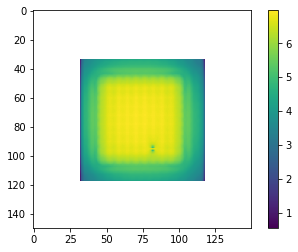

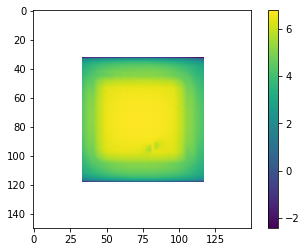

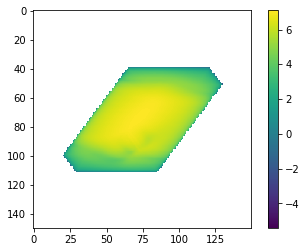

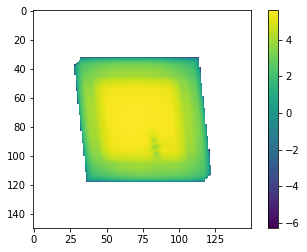

In [62]:
illum_sums[sm.params.n_scan_positions] = []
for spb in sm.simulations_per_peak:
    sum_this = np.abs(spb.projection_slices_all).sum(axis=0)
    illum_sums[sm.params.n_scan_positions].append(sum_this)

    plt.imshow(np.log(sum_this))
    plt.colorbar()
    plt.show()

In [66]:
for i in range(4):
    diffs = sm.simulations_per_peak[i].diffraction_patterns
    print(diffs.max(), diffs.sum(axis=(1,2)).max())

21776 2884820
15460 1844820
14845 845058
1433 179964


In [68]:
for i in range(4):
    diffs = sm.simulations_per_peak[i].diffraction_patterns
    print(diffs.mean(), diffs.sum(axis=(1,2)).mean())

125.7969865569273 2830432.1975308643
78.1840647462277 1759141.4567901234
32.276580521262005 726223.061728395
7.206306721536351 162141.9012345679


In [ ]:
sm.simulations_per_peak[2].rotate_theta

array([[ 1.        ,  0.        ,  0.        ],
       [ 0.        ,  0.47135004, -0.88194622],
       [ 0.        ,  0.88194622,  0.47135004]])

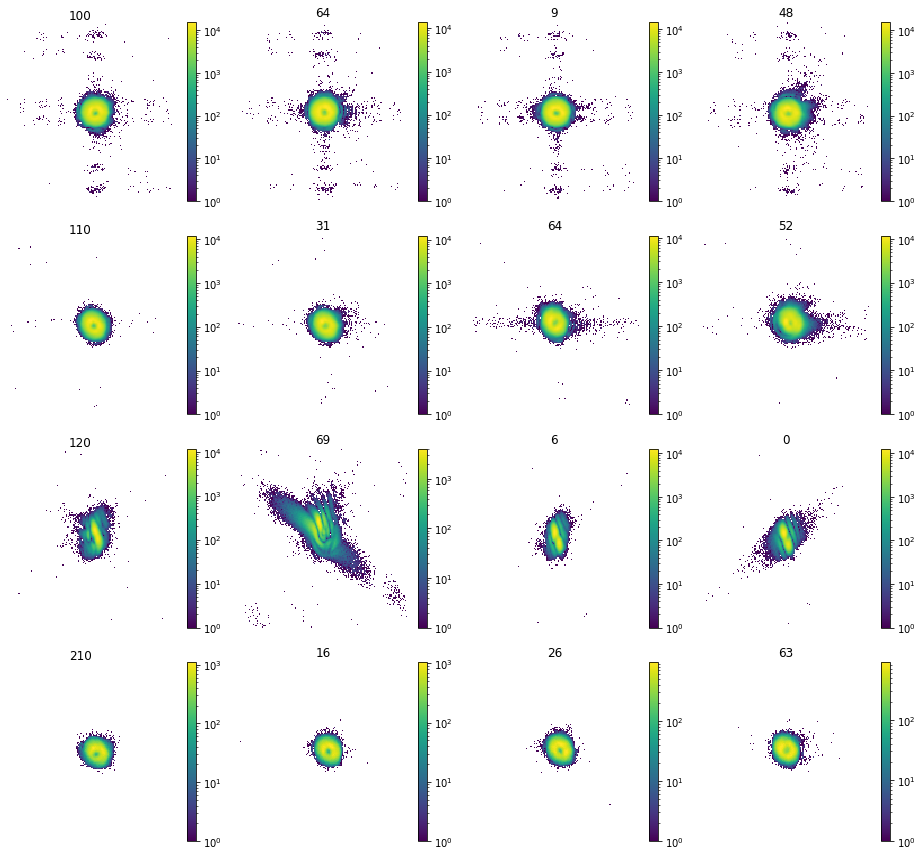

In [73]:
random_indices = np.random.randint(sm.simulations_per_peak[1].diffraction_patterns.shape[0], size=16).reshape(4,4)
fig, axes = plt.subplots(4, 4, figsize=(13, 12))
for i1 in range(4):
    for i2 in range(4):
        diff_this = sm.simulations_per_peak[i1].diffraction_patterns[random_indices[i1, i2]]
        plt.subplot(4, 4, i1 * 4 +  i2 + 1)
        plt.pcolormesh(np.fft.fftshift(diff_this), norm=mpl.colors.LogNorm())
        plt.title(random_indices[i1, i2])
        
        plt.colorbar()
        if i2 == 0: plt.title(''.join(sm.params.HKL_list[i1].astype('str')), ha='right', va='center')
        plt.gca().axis('off')
        #axes(i1, i2)
plt.tight_layout()
        


In [75]:
plots_3d_mask = (~sm.sample.obj_mask_full) #| (~sm.sample.magnitudes_full_mask)

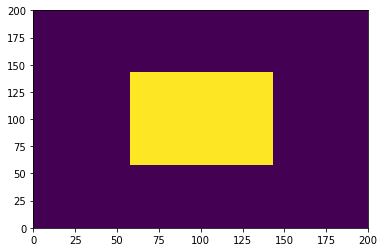

In [76]:
plt.pcolormesh(np.abs(sm.sample.obj_mask_full[...,50]))

In [77]:
ux = sm.sample.Ux_full #/ sm.sample.params.lattice[1]
uy = sm.sample.Uy_full #/ sm.sample.params.lattice[1]
uz = sm.sample.Uz_full #/ sm.sample.params.lattice[1]
dux = np.gradient(ux)#, sm.sample.params.sample_pix_size)
duy = np.gradient(uy)#, sm.sample.params.sample_pix_size)
duz = np.gradient(uz)#, sm.sample.params.sample_pix_size)
du = np.stack([dux, duy, duz], axis=0)

In [108]:
sm.simulations_per_peak[2].rotate_theta

array([[ 1.        ,  0.        ,  0.        ],
       [ 0.        ,  0.47135004, -0.88194622],
       [ 0.        ,  0.88194622,  0.47135004]])

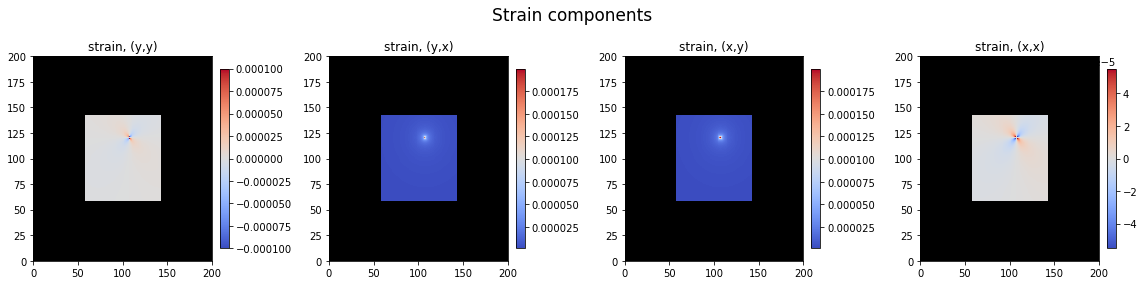

In [78]:
s = np.zeros(du.shape)
fig, axs = plt.subplots(1,4, figsize=(16,4))
coord_axes = {0:'y', 1:'x', 2:'z'}
for i in range(2):
    for j in range(2):
        s[i,j] = 0.5 * (du[j,i] + du[i,j])
        s[i,j][plots_3d_mask] = np.nan
        #s[i,j][~sm.sample.amplitudes_trunc_mask] = np.nan
        if i < 2 and j < 2:
            sl = s[i,j, :, :, 50]
            
        elif i < 2 and j ==2 :
            sl = s[i, j, :,:, 50]
        else:
            sl = s[i, j, :, :, 50]
        
        im = axs[i * 2 + j].pcolormesh(sl, cmap=cmap)
        axs[i * 2 + j].set_title(f'strain, ({coord_axes[i]},{coord_axes[j]})')
        plt.colorbar(im, ax=axs[2*i + j], fraction=0.046, pad=0.04)
plt.suptitle('Strain components', fontsize=17)
plt.tight_layout()

if save_plots:
    plt.savefig(f'{data_path}strain.pdf', bbox_inches='tight')
          
plt.show()  

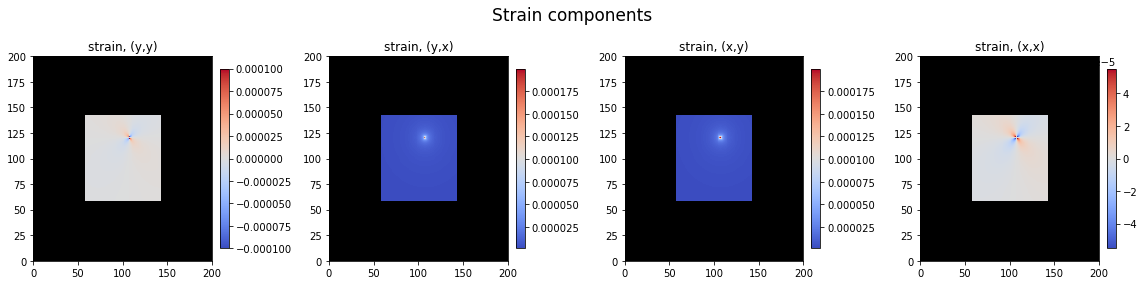

In [79]:
s = np.zeros(du.shape)
fig, axs = plt.subplots(1,4, figsize=(16,4))
coord_axes = {0:'y', 1:'x', 2:'z'}
for i in range(2):
    for j in range(2):
        s[i,j] = 0.5 * (du[j,i] + du[i,j])
        s[i,j][plots_3d_mask] = np.nan
        #s[i,j][~sm.sample.amplitudes_trunc_mask] = np.nan
        if i < 2 and j < 2:
            sl = s[i,j, :, :, 50]
            
        elif i < 2 and j ==2 :
            sl = s[i, j, :,:, 50]
        else:
            sl = s[i, j, :, :, 50]
        
        im = axs[i * 2 + j].pcolormesh(sl, cmap=cmap)
        axs[i * 2 + j].set_title(f'strain, ({coord_axes[i]},{coord_axes[j]})')
        plt.colorbar(im, ax=axs[2*i + j], fraction=0.046, pad=0.04)
plt.suptitle('Strain components', fontsize=17)
plt.tight_layout()

if save_plots:
    plt.savefig(f'{data_path}strain.pdf', bbox_inches='tight')
          
plt.show()  

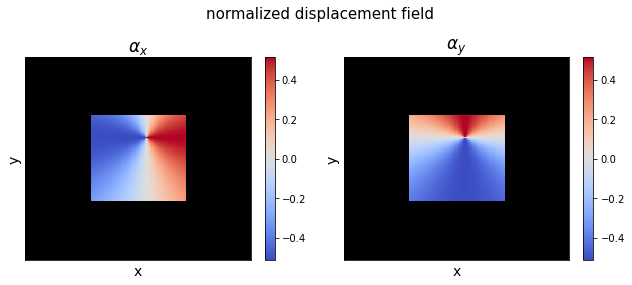

In [80]:
plt.figure(figsize=[9,4])

plt.subplot(1,2,1)
front = sm.sample.Ux_full / sm.sample.params.lattice[1]
front[plots_3d_mask] = np.nan
plt.pcolormesh(front[...,50], cmap=cmap)
plt.colorbar()
#cbar = plt.colorbar(ticks=[-2, -1, 0, 1, 2])
#cbar.ax.tick_params(labelsize=14)
#cbar.ax.set_ylabel(r'$\alpha_y$', fontsize=17) 
plt.xticks([])
plt.yticks([])
plt.xlabel('x', fontsize=14)
plt.ylabel('y', fontsize=14)
plt.title(r'$\alpha_x$', fontsize=17)

plt.subplot(1,2,2)
front = sm.sample.Uy_full / sm.sample.params.lattice[1]
front[plots_3d_mask] = np.nan
#cmap = mpl.cm.get_cmap('coolwarm')
#cmap.set_bad('black')
plt.pcolormesh(front[...,50], cmap=cmap)
plt.colorbar()
#cbar = plt.colorbar(ticks=[-0.2, -0.1, 0, 0.1, 0.2])
#cbar.ax.tick_params(labelsize=14)
#cbar.ax.set_ylabel(r'$\alpha_y$', fontsize=17) 
plt.xticks([])
plt.yticks([])
plt.xlabel('x', fontsize=14)
plt.ylabel('y', fontsize=14)
plt.title(r'$\alpha_y$', fontsize=17)
plt.suptitle("normalized displacement field", fontsize=15)
plt.tight_layout()
if save_plots:
    plt.savefig(f'{data_path}/displacement.pdf', bbox_inches='tight')
plt.show()

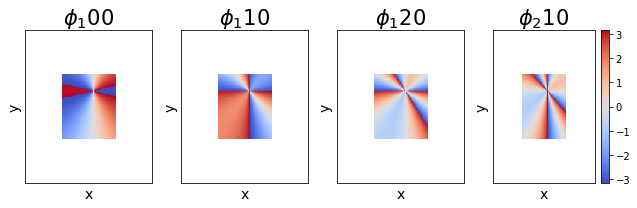

In [81]:
fig, axs = plt.subplots(1, 4, figsize=[9,3])

for i in range(4):
    front = np.angle(sm.sample.rhos[i])
    front[plots_3d_mask] = np.nan
    cax= axs[i].pcolormesh(front[...,50], cmap='coolwarm', vmin=-np.pi, vmax=np.pi)
    peak = ''.join(sm.params.HKL_list[i].astype('str'))
    axs[i].set_xlabel('x', fontsize=14)
    axs[i].set_ylabel('y', fontsize=14)
    axs[i].set_title(fr"$\phi_{peak}$", fontsize=21)
    axs[i].set_xticks([])
    axs[i].set_yticks([])

plt.colorbar(cax, ax=axs[3])
plt.tight_layout()
if save_plots:
    plt.savefig(f'{data_path}/phases.pdf', bbox_inches='tight')
plt.show()

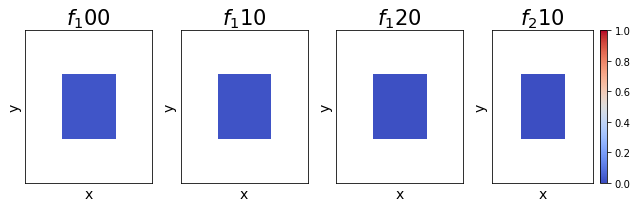

In [82]:
fig, axs = plt.subplots(1, 4, figsize=[9,3])

for i in range(4):
    front = np.abs(sm.rhos[i])
    front[plots_3d_mask] = np.nan
    cax= axs[i].pcolormesh(front[...,51], cmap='coolwarm', vmin=0, vmax=1.0)
    peak = ''.join(sm.params.HKL_list[i].astype('str'))
    axs[i].set_xlabel('x', fontsize=14)
    axs[i].set_ylabel('y', fontsize=14)
    axs[i].set_title(fr"$f_{peak}$", fontsize=21)
    axs[i].set_xticks([])
    axs[i].set_yticks([])

plt.colorbar(cax, ax=axs[3])
plt.tight_layout()
if save_plots:
    plt.savefig(f'{data_path}/magnitudes.png', bbox_inches='tight')
plt.show()

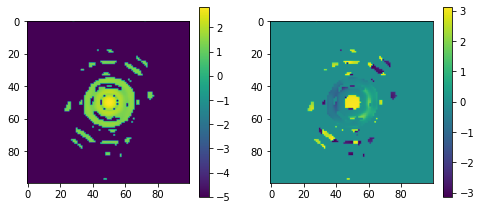

In [83]:
plt.figure(figsize=[8,3.5])
plt.subplot(121)
plt.imshow(np.log10(np.abs(probe_2d) + 1e-5))
plt.colorbar()
plt.subplot(122)
plt.imshow(np.angle(probe_2d))
plt.colorbar()
plt.show()

In [84]:

from matplotlib.colors import LogNorm, Normalize, LinearSegmentedColormap
import matplotlib.font_manager as fm
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from mpl_toolkits.axes_grid1 import make_axes_locatable

class MidpointNormalize(Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))
    
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

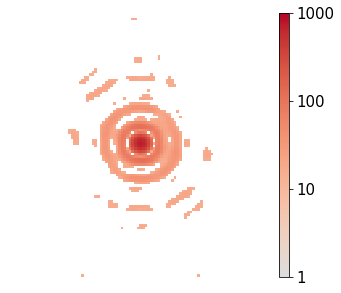

In [75]:
fig, ax = plt.subplots(1,1, figsize=[4, 4], constrained_layout=True)
    

probe_absvals = np.abs(probe_2d)
probe_angvals = np.angle(probe_2d)

#probe_absvals[probe_absvals<1] = 1

new_cmap = truncate_colormap(plt.get_cmap('coolwarm'), minval=0.5, maxval=1)

#plt.sca(axes[0,0])
im = ax.pcolormesh(probe_absvals, cmap=new_cmap, norm=LogNorm(vmin=1, vmax=1000))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="4%", pad=0.1)
cb = plt.colorbar(im, cax=cax, ticks=[1, 10, 100, 1000])
cb.ax.set_yticklabels([1, 10, 100, 1000])
cb.ax.minorticks_off()
cb.ax.tick_params(labelsize=15)

ax.set_aspect('equal')
ax.set_axis_off()
#ax.text(0.05, 1.02, '(' + string.ascii_lowercase[i] + ') ' + list(subplot_titles.values())[i],
#            transform=ax.transAxes, size=16)
plt.savefig('probe_mag.pdf', bbox_inches='tight')

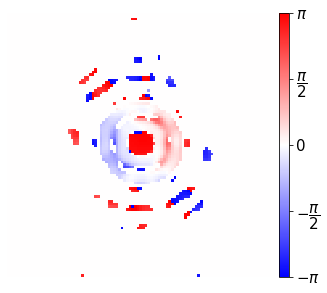

In [76]:
fig, ax = plt.subplots(1,1, figsize=[4, 4], constrained_layout=True)

#probe_angvals[probe_absvals<1] = 0

im = ax.pcolormesh(probe_angvals, cmap='bwr',vmin=-np.pi, vmax=np.pi)
                          # norm=MidpointNormalize(vmin=-np.pi, vmax=np.pi, midpoint=0))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="4%", pad=0.1)
cb = plt.colorbar(im, cax=cax, ticks=[-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
cb.ax.minorticks_off()
cb.ax.set_yticklabels([r'$-\pi$', r'$-\dfrac{\pi}{2}$', r'0',  r'$\dfrac{\pi}{2}$', r'$\pi$'])
cb.ax.tick_params(labelsize=15)

ax.set_axis_off()
ax.set_aspect('equal')

plt.savefig('probe_phase.pdf', bbox_inches='tight')